## Dataset Loading 

In [22]:
%pip install hmmlearn pandas numpy matplotlib

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [23]:
import numpy as np
import pandas as pd
path = "../Dataset/AXISBANK.NS.csv"
prices_hist_data = pd.read_csv(path)



prices_hist_data = prices_hist_data.dropna()
prices_hist_data = prices_hist_data.reset_index(drop=True)
prices_hist_data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-10-29,564.849976,617.900024,558.000000,610.650024,607.715393,49195226.0
1,2018-11-05,628.900024,633.000000,600.049988,613.200012,610.253174,55011591.0
2,2018-11-12,612.549988,636.700012,604.049988,619.799988,616.821411,49062729.0
3,2018-11-19,619.799988,629.400024,608.599976,614.549988,611.596619,30494480.0
4,2018-11-26,618.650024,638.700012,616.500000,625.750000,622.742737,58443729.0
...,...,...,...,...,...,...,...
256,2023-09-25,1015.200012,1041.000000,1004.000000,1036.699951,1036.699951,44017306.0
257,2023-10-02,1036.699951,1044.699951,988.849976,1000.950012,1000.950012,47413699.0
258,2023-10-09,994.799988,1031.000000,988.250000,994.049988,994.049988,37041880.0
259,2023-10-16,990.000000,1014.700012,977.750000,980.349976,980.349976,29071998.0


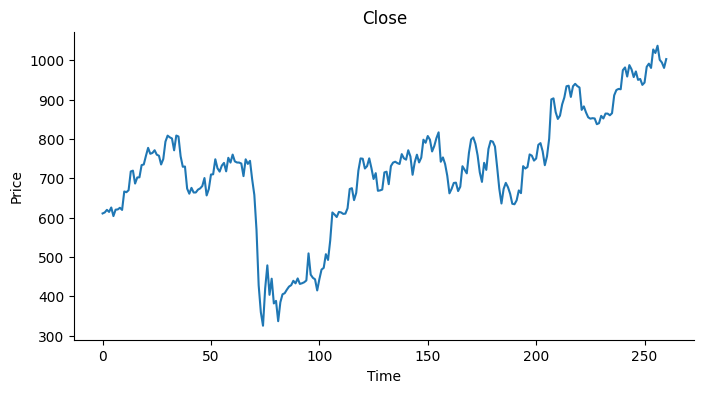

In [24]:
from matplotlib import pyplot as plt
prices_hist_data['Close'].plot(kind='line', figsize=(8, 4), title='Close')
plt.xlabel("Time")
plt.ylabel("Price")
plt.gca().spines[['top', 'right']].set_visible(False)

In [25]:
returns_hist_data = {}
total_data_time = len(prices_hist_data)
returns_hist_data[prices_hist_data['Date'][0]] = 0
prev_price = float(prices_hist_data['Close'][0])

for i in range(1,total_data_time):
    curr_price = float(prices_hist_data['Close'][i])
    returns_hist_data[prices_hist_data['Date'][i]] = (curr_price-prev_price)/prev_price
    prev_price = curr_price

returns_hist_data = pd.DataFrame(data=returns_hist_data.items(),columns=['Date','Returns'])
print(returns_hist_data)

           Date   Returns
0    2018-10-29  0.000000
1    2018-11-05  0.004176
2    2018-11-12  0.010763
3    2018-11-19 -0.008470
4    2018-11-26  0.018225
..          ...       ...
256  2023-09-25  0.018119
257  2023-10-02 -0.034484
258  2023-10-09 -0.006893
259  2023-10-16 -0.013782
260  2023-10-23  0.022849

[261 rows x 2 columns]


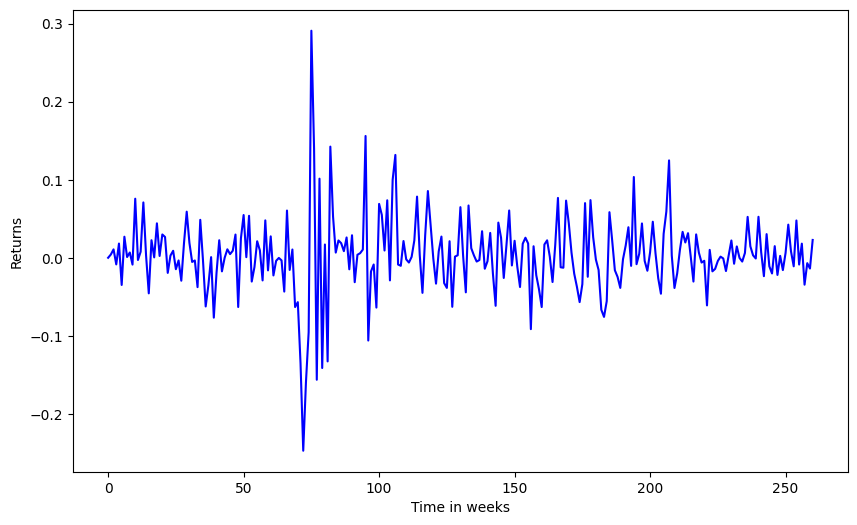

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot([i for i in range(len(returns_hist_data.Returns))],returns_hist_data.Returns,color = 'b')
plt.xlabel('Time in weeks')
plt.ylabel('Returns')
plt.show()

In [27]:
s = pd.DataFrame(returns_hist_data)
s.describe()

,Returns
count,261.000000
mean,0.003172
std,0.050405
min,-0.247275
25%,-0.017021
50%,0.002421
75%,0.022502
max,0.290982


# Hidden Markov Model to estimate the parameters of stock market

In [71]:
import hmmlearn.hmm as hmm

observed_returns = np.array(returns_hist_data['Returns'])

hmm_model = hmm.GaussianHMM(
    n_components=2)

hmm_model.fit(observed_returns.reshape(-1,1))

means = hmm_model.means_
covariances = hmm_model.covars_
transition_matrix = hmm_model.transmat_

print("Estimated Means for Each Regime:")
print(means)
print("Estimated Covariance Matrices for Each Regime:")
print(covariances)
print("Estimated Transition Probabilities:")
print(transition_matrix)

Model is not converging.  Current: 384.98187285880556 is not greater than 419.3861901369784. Delta is -34.40431727817287


Estimated Means for Each Regime:
[[ 0.01772103]
 [-0.01092964]]
Estimated Covariance Matrices for Each Regime:
[[[0.00256098]]

 [[0.00224861]]]
Estimated Transition Probabilities:
[[0.49281745 0.50718255]
 [0.49173087 0.50826913]]


# Dynamic Programming Approach for Single asset

In [16]:
import numpy as np
from scipy.stats import multivariate_normal
def generate_normal_distribution(n):

    L = np.random.rand(n, n)
    cov_matrix = np.dot(L, L.T)

    mean = np.random.randn(n)
    print(mean)

    return [mean,cov_matrix]


n = 1
regimes = []
N = 2
T= 50
rf = (5/50)/100
gama = -1
tpm = np.array([[0.98581142, 0.01418858]
,[0.12509587,0.87490413]])
regimes = [[[ 0.00368291],[[0.00114034]]],[[-0.00135955],  [[0.01559686]]]]

def generate_scenario(prob,t):
    current_regime = np.random.choice(N,p = prob)
    sample = list(np.random.multivariate_normal(mean = regimes[current_regime][0], cov= regimes[current_regime][1]))
    sample.append(rf)
    return np.array(sample)

def generate_monte_carlo_sample():
    sample = []
    curr_regime = np.random.choice(range(N))
    returns = list(np.random.multivariate_normal(mean = regimes[curr_regime][0], cov= regimes[curr_regime][1]))
    returns.append(rf)
    sample.append([curr_regime,returns])
    for i in range(T-1):
        curr_regime = np.random.choice(range(N), p = tpm[curr_regime])
        returns = list(np.random.multivariate_normal(mean = regimes[curr_regime][0], cov= regimes[curr_regime][1]))
        returns.append(rf)
        sample.append([curr_regime,returns])

    return sample


generate_monte_carlo_sample()

[[0, [-0.023754081054800823, 0.001]],
 [0, [0.013354411252020137, 0.001]],
 [0, [0.033537353725291756, 0.001]],
 [0, [0.046562961109519616, 0.001]],
 [0, [0.026081924630809807, 0.001]],
 [0, [0.002989837350198567, 0.001]],
 [0, [0.04450680510880074, 0.001]],
 [0, [0.013591644482895682, 0.001]],
 [0, [0.020156728954233177, 0.001]],
 [0, [-0.02308971714754545, 0.001]],
 [0, [-0.038815977863697004, 0.001]],
 [0, [-0.014629145463689503, 0.001]],
 [0, [0.0077661422119121625, 0.001]],
 [0, [-0.024254930007125395, 0.001]],
 [0, [0.009038612011903636, 0.001]],
 [0, [-0.006689149253140846, 0.001]],
 [0, [-0.050759390500906686, 0.001]],
 [0, [-0.014622598775738089, 0.001]],
 [0, [0.0002063483281378375, 0.001]],
 [0, [-0.07162926893499012, 0.001]],
 [0, [-0.04327824798929503, 0.001]],
 [0, [-0.054857823910327855, 0.001]],
 [0, [0.01672340040597655, 0.001]],
 [0, [-0.06250683746515283, 0.001]],
 [0, [0.008743430309692768, 0.001]],
 [0, [0.015901828411595067, 0.001]],
 [0, [-0.01664732942211225, 0.

In [17]:
generate_scenario([1,0],0)

array([0.0230878, 0.001    ])

In [18]:
print(regimes[1][:])

[[-0.00135955], [[0.01559686]]]


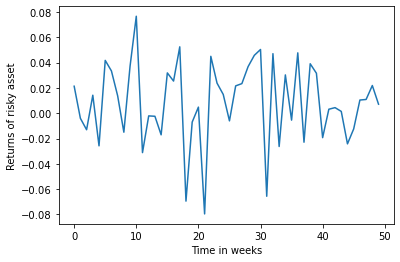

In [19]:
sample_returns = generate_monte_carlo_sample()
import matplotlib.pyplot as plt
x_values = [i for i in range(T)]
y_values = [array[1][0] for array in sample_returns]
regimes_for_this_sample = [array[0] for array in sample_returns]
flig,ax = plt.subplots()
ax.plot(x_values,y_values)
ax.fill_between(x_values,min(y_values),max(y_values),where = [regimes_for_this_sample[i]==1 for i in range(T)],color = 'grey',alpha = 0.5)
plt.xlabel("Time in weeks")
plt.ylabel("Returns of risky asset")
plt.show()

## Probabilty set initialization over different regimes

In [21]:
from itertools import product
from scipy.optimize import minimize
discrete_prob = 50
prob_set = []
for i in range(discrete_prob+1):
    prob_set.append(1/(discrete_prob)*i)

combinations = product(prob_set, repeat=N)
possible_probabities = [vector for vector in combinations if sum(vector) == 1]
reverse_index = {}
for _,p in enumerate(possible_probabities):
    reverse_index[p]= _

possible_probabities = [np.array(x) for x in possible_probabities]


In [22]:
delta_pi = 0.02
pi_set = []
curr_pi = -1
while curr_pi<=1+1e-5:
    pi_set.append(curr_pi)
    curr_pi+=delta_pi

pi_combinations = product(pi_set,repeat=n)
possible_pi = [np.append(np.array(vector),1-np.sum(vector)) for vector in pi_combinations]


In [23]:
print(possible_pi[-1])

[ 1.00000000e+00 -1.11022302e-15]


In [24]:
def closest_probability_distn(p_in):
    lowest_norm = np.array(float('inf'))
    ind = 0

    for _,array in enumerate(possible_probabities):
        norm = np.linalg.norm(p_in - array)
        if norm < lowest_norm:
            lowest_norm = norm
            closest_array = array
            ind = _

    return ind,closest_array

def updateBelief(r,p):
    r = r[:-1]
    density = np.array([multivariate_normal.pdf(r,mean = regimes[i][0], cov = regimes[i][1]) for i in range(N)])
    p_new = tpm.T@(density*p)
    p_new/=np.sum(p_new)
    
    closest_p_ind,_ = closest_probability_distn(p_new)
    return p_new,closest_p_ind

def newWealth(r, pi):
  return np.sum(pi*(1+r))

In [239]:
T = 5
V = {}
for _ in range(len(possible_probabities)):
    V[(_,T)] = (1**gamma)/gamma


t = T-1
M = 10000
pi_l = -1.0
pi_u = 1.0


optimal_pi_star = {}

# scenarios = []_star = {}
for iter in range(1):
    # scenarios = []
    # for j in range(M):
    #     sample = generate_monte_carlo_sample()
    #     scenarios.append(sample)
    # print("Samples generated")
    t = T-1
    while (t>=0):
        # returns_at_this_time = [scenarios[i][t][1] for i in range(M)]
        #print(returns_at_this_time)
        for _ in range(len(possible_probabities)):
            returns_at_this_time = []
            updateBelief_saved = np.zeros(M)
            for j in range(M):
                sample = generate_scenario(possible_probabities[_],t)
                returns_at_this_time.append(sample)
                updateBelief_saved[j] = updateBelief(sample,possible_probabities[_])[1]

            # print(updateBelief_saved)
            def objective_function(pi):
                return np.average(np.array([(newWealth(returns_at_this_time[i],pi)**gamma)*V[(updateBelief_saved[i],t+1)] for i in range(M)]))

            # constraints = ([{'type': 'eq', 'fun': lambda pi: np.sum(pi) - 1}])  
            # initial_pi_guess = np.ones(n+1)/(n+1)
            # if(_):
            #     initial_pi_guess = optimal_pi_star[(_-1,t)]
            

            # pi_star = minimize(lambda x: (-1)*objective_function(x),  initial_pi_guess,
            #                    constraints=constraints,
            #                     bounds = [(pi_l,pi_u) for i in range(n)] + [(None,None)],
            #                   )

            # print(pi_star.message)
            # pi_star = pi_star.x


            pi_star = max(possible_pi,key = objective_function)
            
            V[(_,t)] = np.average([(newWealth(returns_at_this_time[i],pi_star)**gamma)*V[(updateBelief_saved[i],t+1)] for i in range(M)])
            optimal_pi_star[(_,t)] = pi_star
            print(iter,t,possible_probabities[_],pi_star)

        t= t-1
        print("\n")



0 4 [0. 1.] [-0.08  1.08]
0 4 [0.02 0.98] [-0.08  1.08]
0 4 [0.04 0.96] [-0.08  1.08]
0 4 [0.06 0.94] [-0.04  1.04]
0 4 [0.08 0.92] [-0.08  1.08]
0 4 [0.1 0.9] [-0.08  1.08]
0 4 [0.12 0.88] [-0.16  1.16]
0 4 [0.14 0.86] [-0.04  1.04]
0 4 [0.16 0.84] [6.17561557e-16 1.00000000e+00]
0 4 [0.18 0.82] [-0.08  1.08]
0 4 [0.2 0.8] [-0.06  1.06]
0 4 [0.22 0.78] [6.17561557e-16 1.00000000e+00]
0 4 [0.24 0.76] [-0.06  1.06]
0 4 [0.26 0.74] [-0.04  1.04]
0 4 [0.28 0.72] [-0.06  1.06]
0 4 [0.3 0.7] [-0.06  1.06]
0 4 [0.32 0.68] [6.17561557e-16 1.00000000e+00]
0 4 [0.34 0.66] [-0.04  1.04]
0 4 [0.36 0.64] [6.17561557e-16 1.00000000e+00]
0 4 [0.38 0.62] [-0.06  1.06]
0 4 [0.4 0.6] [0.02 0.98]
0 4 [0.42 0.58] [6.17561557e-16 1.00000000e+00]
0 4 [0.44 0.56] [0.02 0.98]
0 4 [0.46 0.54] [0.02 0.98]
0 4 [0.48 0.52] [-0.06  1.06]
0 4 [0.5 0.5] [6.17561557e-16 1.00000000e+00]
0 4 [0.52 0.48] [-0.12  1.12]
0 4 [0.54 0.46] [0.02 0.98]
0 4 [0.56 0.44] [0.1 0.9]
0 4 [0.58 0.42] [0.12 0.88]
0 4 [0.6 0.4] [0.08 

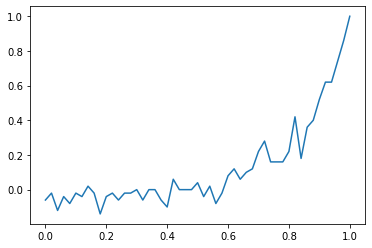

In [242]:
import matplotlib.pyplot as plt

xpoints = [x[0] for x in possible_probabities]
ypoints = [optimal_pi_star[_,2][0] for _ in range(len(possible_probabities))]

plt.plot(xpoints,ypoints)
plt.show()

#print([optimal_pi_star[_,0] for _ in range(5)])

In [241]:
import pickle


with open("Axis_DP_rf5_V_values.pkl", "wb") as fp:
    pickle.dump(V, fp)  

with open("Axis_DP_rf5_optimal_allocation.pkl", "wb") as fp:
    pickle.dump(optimal_pi_star, fp)  

## Loading results

In [25]:
import pickle

with open('Axis_DP_rf5_V_values.pkl', "rb") as fp:
    V = pickle.load(fp)

with open("Axis_DP_rf5_optimal_allocation.pkl", "rb") as fp:
    optimal_pi_star = pickle.load(fp)

## Random path observation

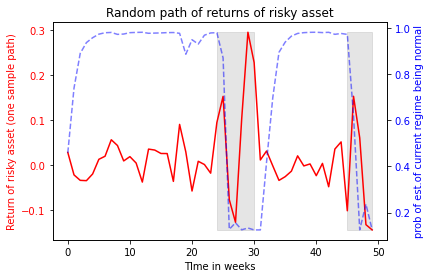

In [26]:
sample_returns = generate_monte_carlo_sample()

initial_belief = np.random.rand(N)
initial_belief/=np.sum(initial_belief)

belief_values = [initial_belief[0]]
prev_belief = initial_belief

for i in range(T):
    upd_belief,_ = updateBelief(sample_returns[i][1],prev_belief)
    belief_values.append(upd_belief[0])
    prev_belief = upd_belief

import matplotlib.pyplot as plt
x_values = [i for i in range(T)]
y_values = [array[1][0] for array in sample_returns]
regimes_for_this_sample = [array[0] for array in sample_returns]
fig,ax1 = plt.subplots()
ax1.plot(x_values,y_values,color = 'r')
ax1.fill_between(x_values,min(y_values),max(y_values),where = [regimes_for_this_sample[i]==1 for i in range(T)],color = 'grey',alpha = 0.2)
ax1.set_xlabel("TIme in weeks")
ax1.set_ylabel("Return of risky asset (one sample path)",color='r')
ax1.tick_params(axis = 'y',labelcolor = 'r')

ax2 = ax1.twinx()
ax2.set_ylabel('prob of est.of current regime being normal', color = 'b') 
ax2.plot(x_values, belief_values[:-1], color = 'b',linestyle ='--',alpha = 0.5)  
ax2.tick_params(axis = 'y',labelcolor = 'b')

plt.title("Random path of returns of risky asset")
plt.show()

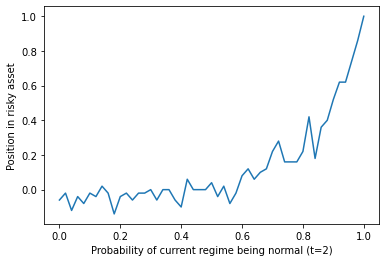

In [27]:
import matplotlib.pyplot as plt

xpoints = [x[0] for x in possible_probabities]
ypoints = [optimal_pi_star[_,2][0] for _ in range(len(possible_probabities))]

plt.plot(xpoints,ypoints)
plt.xlabel("Probability of current regime being normal (t=2)")
plt.ylabel("Position in risky asset")
plt.show()

#print([optimal_pi_star[_,0] for _ in range(5)])

## Test for random path

In [81]:
import torch
def generate_random_path(n_samples):
    input_data = []
    return_samples= []
    for i in range(n_samples):
        sample = generate_monte_carlo_sample()
        
        returns_for_this_sample = []
        for time in range(T):
            returns_for_this_sample.append(sample[time][1])
        return_samples.append(np.array(returns_for_this_sample))
        
        initial_p = np.random.rand(N)
        initial_p/=np.sum(initial_p)
        #plot_x.append(initial_p[0])
        
        input_to_rnn = [initial_p]
        for time in range(T-1):
            p = input_to_rnn[-1]
            p_new,___ = updateBelief(sample[time][1],p)
            #p_new = closest_probability_distn(p_new)[1]
            
            input_to_rnn.append(p_new)
        input_data.append(input_to_rnn)

    return input_data,return_samples

random_path= generate_random_path(1)
random_beliefs, random_returns = random_path[0][0],random_path[1][0]
print(random_beliefs,random_returns)

[array([0.1402313, 0.8597687]), array([0.24692804, 0.75307196]), array([0.57209129, 0.42790871]), array([0.8265041, 0.1734959]), array([0.93462841, 0.06537159])] [[ 0.060592    0.001     ]
 [-0.01283784  0.001     ]
 [-0.01287825  0.001     ]
 [-0.01227766  0.001     ]
 [ 0.00704451  0.001     ]]


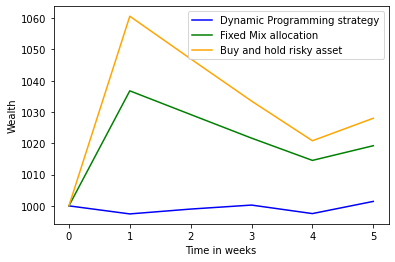

In [82]:
test_wealth = [1000]
transaction_rate = 0.005
test_inital_portfolio = np.random.rand(n+1)
test_inital_portfolio = test_inital_portfolio/np.sum(test_inital_portfolio)
transaction_rate_wealth = [1000]
prev_portfolio = test_inital_portfolio
prev_portfolio  = test_inital_portfolio

for i in range(T):
    closest_ind,_  = closest_probability_distn(random_beliefs[i])
    optimal_alloc = optimal_pi_star[(closest_ind,i)]
    prev_wealth = test_wealth[-1]
    new_wealth = prev_wealth*newWealth(random_returns[i],optimal_alloc)
    test_wealth.append(new_wealth)

    new_wealth_with_transaction = prev_wealth-prev_wealth*transaction_rate*np.linalg.norm(prev_portfolio-optimal_alloc,ord= 1)
    new_wealth_with_transaction = np.sum(optimal_alloc*new_wealth_with_transaction*(1+random_returns[i]))
    transaction_rate_wealth.append(new_wealth_with_transaction)

    curr_portfolio = prev_portfolio*(1+random_returns[i])
    curr_portfolio/=np.sum(curr_portfolio)
    prev_portfolio = curr_portfolio
    


fixed_strategy = np.array(([0.6,0.4]))
wealth_fixed_strategy = [1000]
for i in range(T):
    prev_wealth = wealth_fixed_strategy[-1]
    new_wealth = prev_wealth*np.sum(fixed_strategy*(1+random_returns[i]))
    curr_allocation = fixed_strategy*(1+random_returns[i])
    curr_allocation/=np.sum(curr_allocation)
    #new_wealth -= transaction_rate*new_wealth*.norm(fixed_strategy-curr_allocation,p = 1)
    wealth_fixed_strategy.append(new_wealth)


wealth_buy_and_hold = [1000]
for i in range(T):
    prev_wealth = wealth_buy_and_hold[-1]
    new_wealth = prev_wealth*(1+random_returns[i][0]).item()
    wealth_buy_and_hold.append(new_wealth)

import matplotlib.pyplot as plt
plt.plot([i for i in range(T+1)],test_wealth,color ='b',label = 'Dynamic Programming strategy')
plt.plot([i for i in range(T+1)],wealth_fixed_strategy,color ='g',label = 'Fixed Mix allocation')
plt.plot([i for i in range(T+1)],wealth_buy_and_hold,color ='orange',label = 'Buy and hold risky asset')
plt.xlabel("Time in weeks")
plt.ylabel("Wealth")
plt.legend()
plt.show()

[1000, 991.2067808899153, 992.8048864197177, 994.3073179135075, 994.6317263772885, 1000.5477854986627]


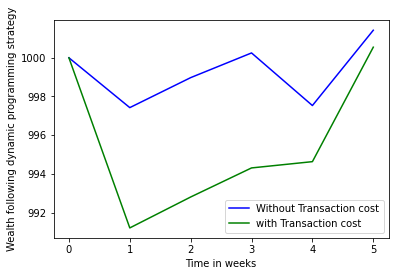

In [83]:
import matplotlib.pyplot as plt
print(transaction_rate_wealth)
plt.plot([i for i in range(T+1)],test_wealth,color ='b',label = 'Without Transaction cost')
plt.plot([i for i in range(T+1)],transaction_rate_wealth,color ='g',label = 'with Transaction cost')
plt.xlabel("Time in weeks")
plt.ylabel("Wealth following dynamic programming strategy")
plt.legend()
plt.show()